In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import collections
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask
import dask.dataframe as dd

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Selecting control from similarity
- Find top 100 most similar patents
- For each in the 100:
    - What has forward citations?
    - What is in same PC?
    - What has closest grant year?


In [3]:
from gensim import models
from gensim.models.word2vec import Word2Vec
pm = Word2Vec.load("DataStore/2018-07-P2/ML/doc2vec_0712.model")

In [5]:
pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pat_dict = dict(zip(pat_dict, range(len(pat_dict))))

In [48]:
ts = pd.read_pickle("DataStore/2018-07-P2/targ_samp_0717.pkl")

# Only in dict
ts = ts.loc[ts["tp"].isin(pat_dict.keys())]

# Drop duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl").tolist()
# Get relevant US Patents
ts = ts.loc[~ts["tp"].isin(dup_pats)]

ts = ts[["tp", "tp_primclass", "tp_gyear", "tp_inv_msa", "tp_match_5", "tp_match_10"]]
ts["tp_id"] = ts["tp"].astype(str)

In [ ]:
def get_most_sim(pat, n):
    try:
        ms = pm.docvecs.most_similar(pat, topn=n)
    except Exception:
        ms = [(np.nan, np.nan)]
    return ms

%time ts_sp = [get_most_sim(i, 50) for i in ts["tp_id"].tolist()]
%time ts_sp = pd.DataFrame({"tp": ts["tp"], "closest_pat": [np.array([i[0] for i in j]) for j in ts_sp],\
                     "closest_pat_sim": [np.array([i[1] for i in j]) for j in ts_sp]})

Took maybe 6 hours?

In [ ]:
ts_sp.to_pickle("DataStore/2018-11/closest_nbrs_1105.pkl")

### Find most relevant patents

In [90]:
ts_sp = pd.read_pickle("DataStore/2018-11/closest_nbrs_1105.pkl")

In [91]:
ts_sp["closest_pat"] = ts_sp["closest_pat"].apply(lambda x: x.astype(float))

print(len(ts_sp))
ts_sp = ts_sp.loc[~(ts_sp["closest_pat"].apply(lambda x: np.isnan(x[0])))]
print(len(ts_sp))

# Make dictionary of patents and sim for each tp
sim_dict = {p: dict(zip(i,j)) for p,i,j in zip(ts_sp["tp"], ts_sp["closest_pat"], ts_sp["closest_pat_sim"])}

282079
197506


In [92]:
# 1. Patents with forward citations
cit = fastparquet.ParquetFile("RawData/Cleaned/cit_0628.parq").to_pandas(["cited"])["cited"].unique()
all_closest = np.concatenate(ts_sp["closest_pat"].tolist()).ravel()
cit = set(set(all_closest).intersection(cit))
# cit = set(cit)
%time cp_cited = [np.array(list(set(x).intersection(cit))) for x in iter(ts_sp["closest_pat"])]

CPU times: user 40.9 s, sys: 116 ms, total: 41 s
Wall time: 42.1 s


In [105]:
# 2. Patents from different assignee
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
%time tp_asgs = [set(asgs.get(p, [])) for p in ts_sp["tp"]]
%time cp_cited_asgs = [np.array([len(set(asgs.get(cp, [])).intersection(tasg)) for cp in j]) for j, tasg in zip(cp_cited, tp_asgs)]
%time cp_cited_asgs_ind = [np.where(j == 0) for j in cp_cited_asgs]
del(asgs)

cp_cited2 = [x[i] for x,i in zip(cp_cited, cp_cited_asgs_ind)]

CPU times: user 1.32 s, sys: 36 ms, total: 1.35 s
Wall time: 1.35 s
CPU times: user 27.6 s, sys: 47.2 ms, total: 27.6 s
Wall time: 27.6 s
CPU times: user 911 ms, sys: 45.9 ms, total: 957 ms
Wall time: 956 ms


In [109]:
# 3. Minimum difference to the target
%time min_diff = [np.argsort(np.abs(x-p))[:5] for x,p in zip(cp_cited2, ts_sp["tp"])]
%time min_diff_cited = [x[i] for x,i in zip(cp_cited2, min_diff)]

CPU times: user 2.98 s, sys: 23.7 ms, total: 3 s
Wall time: 2.8 s
CPU times: user 183 ms, sys: 1.05 ms, total: 184 ms
Wall time: 172 ms


### New dataframe with 5 closest patents in similarity and in grant date

In [120]:
ts2 = ts_sp[["tp"]]
ts2["closest_pat_5"] = min_diff_cited
%time ts2["closest_pat_5_sim"] = [np.array([sim_dict[p][i] for i in j]) for p, j in zip(ts2["tp"], ts2["closest_pat_5"])]
ts2["closest_pat"] = [i[0] if len(i) > 0 else np.nan for i in min_diff_cited]
ts2["closest_pat_sim"] = [i[0] if len(i) > 0 else np.nan for i in ts2["closest_pat_5_sim"]]
print(len(ts2))
ts2 = ts2.loc[ts2["closest_pat"].notnull()]
print(len(ts2))


/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 2.46 s, sys: 3.25 ms, total: 2.46 s
Wall time: 2.39 s
197506
197443


In [121]:
ts = pd.read_pickle("DataStore/2018-07-P2/targ_samp_0717.pkl")
ts2 = ts2.merge(ts[["tp", "tp_primclass", "tp_gyear", "tp_inv_msa", "tp_match_10", "cp_match_10"]], how="left", on = "tp")

In [122]:
ts2.head()

,tp,closest_pat_5,closest_pat_5_sim,closest_pat,closest_pat_sim,tp_primclass,tp_gyear,tp_inv_msa,tp_match_10,cp_match_10
0,5241648,"[5412804.0, 4849219.0, 5639532.0, 4779792.0, 5...","[0.5511770844459534, 0.5152451992034912, 0.518...",5412804.0,0.551177,1.0,1993,"San Jose-Sunnyvale-Santa Clara, CA",0.285714,0.151261
1,7502777,"[7529754.0, 7472396.0, 7424711.0, 7580944.0, 7...","[0.5335527062416077, 0.4992726743221283, 0.502...",7529754.0,0.533553,1.0,2009,"San Jose-Sunnyvale-Santa Clara, CA",0.000000,0.000000
2,7599939,"[7536450.0, 7698251.0, 7490146.0, 7460837.0, 7...","[0.5319807529449463, 0.49737560749053955, 0.48...",7536450.0,0.531981,1.0,2009,"San Jose-Sunnyvale-Santa Clara, CA",0.250000,0.103448
3,5021995,"[5091868.0, 4946782.0, 4939674.0, 4903229.0, 5...","[0.5143916010856628, 0.5080559253692627, 0.517...",5091868.0,0.514392,1.0,1991,"Boston-Cambridge-Quincy, MA-NH",0.000000,0.250000
4,7043476,"[7029121.0, 7076485.0, 6912549.0, 7214065.0, 6...","[0.4758482575416565, 0.4910343587398529, 0.465...",7029121.0,0.475848,1.0,2006,"New York-Northern New Jersey-Long Island, NY-N...",0.000000,0.016949


### Get location of citing patents for each of the closest patents

In [135]:
# all_p = [item for sublist in ts2["closest_pat_5"] for item in sublist]

cit = fastparquet.ParquetFile("RawData/Cleaned/cit_0628.parq").to_pandas()
c2 = cit.loc[cit["cited"].isin(all_p)]
del(cit)
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
# Remove self-citations
%time asg_match = (set(asgs.get(cited, [])).intersection(asgs.get(citing, [])) for cited, citing \
                       in zip(c2["cited"], c2["citing"]))
%time asg_match = [len(i) for i in asg_match]
del(asgs)
c2["asg_match"] = asg_match
c2 = c2.loc[c2["asg_match"] == 0]
c2 = c2[["citing", "cited"]]


pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "inv_msa", "gyear"])

# Citing patents granted in 10 years of cited
gy = dict(zip(pdf["patent"], pdf["gyear"]))
c2["cited_gyear"] = c2["cited"].map(gy)
c2["citing_gyear"] = c2["citing"].map(gy)
c2["diff"] = c2["citing_gyear"] - c2["cited_gyear"]
print(len(c2))
c2 = c2.loc[c2["diff"] <= 10]
print(len(c2))

# Get location of each citing patent
msa = dict(zip(pdf["patent"], pdf["inv_msa"]))
c2["citing_inv_msa"] = c2["citing"].map(msa)

CPU times: user 1.01 s, sys: 487 ms, total: 1.49 s
Wall time: 1.5 s
CPU times: user 53.6 s, sys: 102 ms, total: 53.7 s
Wall time: 53.4 s
12333353
3111609


In [192]:
c2.head()

,citing,cited,cited_gyear,citing_gyear,diff,citing_inv_msa
index,,,,,,
48,7686570,6871502,2005.0,2010.0,5.0,"Orlando-Kissimmee-Sanford, FL"
105,6405197,5717914,1998.0,2002.0,4.0,"San Jose-Sunnyvale-Santa Clara, CA"
108,8874102,7142661,2006.0,2014.0,8.0,"Rochester, NY"
141,5987537,5291604,1994.0,1999.0,5.0,"Houston-Sugar Land-Baytown, TX"
170,6831929,6208632,2001.0,2004.0,3.0,"Dallas-Fort Worth-Arlington, TX"


In [146]:
# # Dictionary of cited patent to citing locations
# %time cit = {n: g["citing_inv_msa"].tolist() for n,g in c2[["cited", "citing_inv_msa"]].groupby("cited")}

# # Location of citing patent for each closest_patent list
# # List of lists of locations
# %time loc_cit = ([cit.get(cp, []) for cp in j] for j in ts2["closest_pat_5"].tolist())
# # Concatenate list for each tp
# %time loc_cit = [[item for sublist in l for item in sublist] for l in loc_cit]
# %time loc_cit = [np.array([i == tp_msa for i in j]) for j,tp_msa in zip(loc_cit, ts2["tp_inv_msa"])]
# Proportion of True
%time loc_cit = [len(j[np.where(j == True)])/len(j) if len(j) >0 else np.nan for j in loc_cit]

CPU times: user 1.83 s, sys: 2.25 ms, total: 1.83 s
Wall time: 1.77 s


In [148]:
ts2["closest_5_match"] = loc_cit

In [153]:
# Closest neighbour match
# Location of citing patent for each closest_patent list
# List of lists of locations
%time loc_cit = (cit.get(cp, []) for cp in ts2["closest_pat"].tolist())
%time loc_cit = [np.array([i == tp_msa for i in j]) for j,tp_msa in zip(loc_cit, ts2["tp_inv_msa"])]
# Proportion of True
%time loc_cit = [len(j[np.where(j == True)])/len(j) if len(j) >0 else np.nan for j in loc_cit]

CPU times: user 7.02 ms, sys: 1.99 ms, total: 9.01 ms
Wall time: 8.22 ms
CPU times: user 1.23 s, sys: 9.23 ms, total: 1.24 s
Wall time: 1.18 s
CPU times: user 700 ms, sys: 1.13 ms, total: 701 ms
Wall time: 668 ms


In [160]:
ts2["closest_pat_match"] = loc_cit
del(cit)

In [155]:
ts2.describe()

,tp,closest_pat,closest_pat_sim,tp_primclass,tp_gyear,tp_match_10,cp_match_10,closest_5_match,closest_pat_match
count,1.974430e+05,1.974430e+05,197443.000000,197443.000000,197443.000000,197443.000000,158090.000000,194767.000000,123995.000000
mean,6.113596e+06,6.113234e+06,0.519520,370.994348,1998.260582,0.111420,0.045317,0.054024,0.053048
std,1.299113e+06,1.297836e+06,0.055924,197.562795,10.086002,0.249267,0.158954,0.126978,0.173798
min,3.930273e+06,3.930282e+06,0.378914,1.000000,1976.000000,0.000000,0.000000,0.000000,0.000000
25%,5.048790e+06,5.048479e+06,0.484988,224.000000,1991.000000,0.000000,0.000000,0.000000,0.000000
50%,6.016269e+06,6.015727e+06,0.509686,370.000000,2000.000000,0.000000,0.000000,0.000000,0.000000
75%,7.117426e+06,7.117488e+06,0.540773,482.000000,2006.000000,0.041667,0.000000,0.045455,0.000000
max,9.043942e+06,9.218209e+06,0.972122,850.000000,2015.000000,1.000000,1.000000,1.000000,1.000000


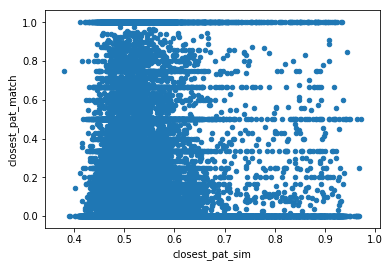

In [157]:
%matplotlib inline
ts2.plot.scatter(x="closest_pat_sim", y="closest_pat_match")

In [158]:
ts2.corr()

,tp,closest_pat,closest_pat_sim,tp_primclass,tp_gyear,tp_match_10,cp_match_10,closest_5_match,closest_pat_match
tp,1.000000,0.997809,0.066276,0.235906,0.976826,0.063023,0.050929,0.067010,0.045953
closest_pat,0.997809,1.000000,0.067402,0.236629,0.974875,0.063217,0.050964,0.066943,0.045824
closest_pat_sim,0.066276,0.067402,1.000000,0.112898,0.062152,0.050135,0.025678,0.074547,0.093623
tp_primclass,0.235906,0.236629,0.112898,1.000000,0.229919,0.020014,0.064146,0.069153,0.043547
tp_gyear,0.976826,0.974875,0.062152,0.229919,1.000000,0.058957,0.047615,0.061965,0.042097
tp_match_10,0.063023,0.063217,0.050135,0.020014,0.058957,1.000000,0.118365,0.204928,0.156654
cp_match_10,0.050929,0.050964,0.025678,0.064146,0.047615,0.118365,1.000000,0.175957,0.125803
closest_5_match,0.067010,0.066943,0.074547,0.069153,0.061965,0.204928,0.175957,1.000000,0.570148
closest_pat_match,0.045953,0.045824,0.093623,0.043547,0.042097,0.156654,0.125803,0.570148,1.000000


In [159]:
ts2.to_pickle("DataStore/2018-11/closest_nbr_control_1108.pkl")

## Selecting controls based on lawyers

In [162]:
# ldf = pd.read_csv("RawData/Cleaned/patent_lawyer.csv")
# pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
# .to_pandas(["patent", "primclass"])
# ldf["primclass"] = ldf["patent"].map(dict(zip(pdf["patent"], pdf["primclass"])))
%time ldf = {n:g["patent"].values for n,g in ldf[["patent", "lawyer_id", "primclass"]].groupby(["lawyer_id", "primclass"])}

CPU times: user 3min 23s, sys: 155 ms, total: 3min 23s
Wall time: 3min 26s


In [168]:
# ts3 = ts2[["tp", "tp_gyear", "tp_primclass", "tp_inv_msa"]]

# # Target lawyers
# ldf2 = pd.read_csv("RawData/Cleaned/patent_lawyer.csv")
%time ldf2 = {n:g["lawyer_id"].tolist() for n,g in ldf2[["patent", "lawyer_id"]].groupby(["patent"])}

ts3["tp_lawyer"] = ts3["tp"].map(ldf2)
del(ldf2)

CPU times: user 22min 39s, sys: 509 ms, total: 22min 39s
Wall time: 22min 39s


/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [172]:
ts3.to_pickle("DataStore/2018-11/lawyer_control_1108.pkl")

In [182]:
# Only patents with lawyers
print(len(ts3))
ts3 = ts3.loc[ts3["tp_lawyer"].notnull() & ts3["tp_primclass"].notnull()]
print(len(ts3))
# Lawyer patents in same primary class
%time lp = [[ldf.get((l,pc), []) for l in j] for pc,j in zip(ts3["tp_primclass"], ts3["tp_lawyer"])]
%time lp = [np.array([item for sublist in j for item in sublist]) for j in lp]

197443
178762
CPU times: user 1.09 s, sys: 6.16 ms, total: 1.09 s
Wall time: 1.05 s
CPU times: user 2.21 s, sys: 1.35 ms, total: 2.21 s
Wall time: 2.13 s


In [184]:
# 1. Patents with forward citations
cit = fastparquet.ParquetFile("RawData/Cleaned/cit_0628.parq").to_pandas(["cited"])["cited"].unique()
all_closest = np.concatenate(lp).ravel()
cit = set(set(all_closest).intersection(cit))
# cit = set(cit)
%time cp_cited = [np.array(list(set(x).intersection(cit))) for x in iter(lp)]

CPU times: user 31 s, sys: 6.28 ms, total: 31 s
Wall time: 29.7 s


In [185]:
# 2. Patents from different assignee
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
%time tp_asgs = [set(asgs.get(p, [])) for p in ts3["tp"]]
%time cp_cited_asgs = [np.array([len(set(asgs.get(cp, [])).intersection(tasg)) for cp in j]) for j, tasg in zip(cp_cited, tp_asgs)]
%time cp_cited_asgs_ind = [np.where(j == 0) for j in cp_cited_asgs]
del(asgs)

cp_cited2 = [x[i] for x,i in zip(cp_cited, cp_cited_asgs_ind)]

CPU times: user 3.57 s, sys: 57.6 ms, total: 3.63 s
Wall time: 3.47 s
CPU times: user 15.6 s, sys: 16.3 ms, total: 15.6 s
Wall time: 16.8 s
CPU times: user 1.24 s, sys: 22.9 ms, total: 1.26 s
Wall time: 1.29 s


In [227]:
# # 3. Patents from different MSAs
# msas = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
# .to_pandas(["patent", "inv_msa", "gyear"]) 
# msas = dict(zip(msas["patent"], msas["inv_msa"]))
# cp_cited_msas = [[msas[cp] == tp_msa for cp in j] for j, tp_msa in zip(cp_cited2, ts3["tp_inv_msa"])]
cp_cited_msas_ind = [np.where(np.array(j) == False) for j in cp_cited_msas]

cp_cited3 = [x[i] for x,i in zip(cp_cited2, cp_cited_msas_ind)]

In [229]:
# 3. Minimum difference to the target
%time min_diff = [np.argsort(np.abs(x-p))[:5] for x,p in zip(cp_cited3, ts3["tp"])]
%time min_diff_cited = [x[i] for x,i in zip(cp_cited2, min_diff)]

CPU times: user 2.64 s, sys: 15.5 ms, total: 2.65 s
Wall time: 2.78 s
CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 244 ms


In [230]:
ts3["lawyer_cp_5"] = min_diff_cited
ts3["lawyer_cp"] = [i[0] if len(i) >0 else np.nan for i in min_diff_cited]

In [231]:
ts3.to_pickle("DataStore/2018-11/lawyer_control_1108.pkl")

### Location of lawyer control citations

In [232]:
# Dictionary of cited patent to citing locations
# %time cit = {n: g["citing_inv_msa"].tolist() for n,g in c2[["cited", "citing_inv_msa"]].groupby("cited")}

# Location of citing patent for each closest_patent list
# List of lists of locations
%time loc_cit = ([cit.get(cp, []) for cp in j] for j in ts3["lawyer_cp_5"].tolist())
# Concatenate list for each tp
%time loc_cit = [[item for sublist in l for item in sublist] for l in loc_cit]
%time loc_cit = [np.array([i == tp_msa for i in j]) for j,tp_msa in zip(loc_cit, ts3["tp_inv_msa"])]
# Proportion of True
%time loc_cit = [len(j[np.where(j == True)])/len(j) if len(j) >0 else np.nan for j in loc_cit]

CPU times: user 8.21 ms, sys: 0 ns, total: 8.21 ms
Wall time: 7.98 ms
CPU times: user 1.3 s, sys: 5.09 ms, total: 1.31 s
Wall time: 1.28 s
CPU times: user 637 ms, sys: 41 µs, total: 637 ms
Wall time: 627 ms
CPU times: user 367 ms, sys: 28 µs, total: 367 ms
Wall time: 360 ms


In [233]:
ts3["lawyer_5_match"] = loc_cit

In [234]:
# Closest neighbour match
# Location of citing patent for each closest_patent list
# List of lists of locations
%time loc_cit = (cit.get(cp, []) for cp in ts3["lawyer_cp"].tolist())
%time loc_cit = [np.array([i == tp_msa for i in j]) for j,tp_msa in zip(loc_cit, ts3["tp_inv_msa"])]
# Proportion of True
%time loc_cit = [len(j[np.where(j == True)])/len(j) if len(j) >0 else np.nan for j in loc_cit]

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 12.8 ms
CPU times: user 1.52 s, sys: 3.1 ms, total: 1.53 s
Wall time: 1.5 s
CPU times: user 355 ms, sys: 1.02 ms, total: 356 ms
Wall time: 350 ms


In [235]:
ts3["lawyer_cp_match"] = loc_cit
# del(cit)

In [243]:
ts3.loc[ts3["lawyer_cp"].notnull() & ts3["lawyer_cp_match"].notnull()].describe()

,tp,tp_gyear,tp_primclass,lawyer_cp,lawyer_5_match,lawyer_cp_match,tp_match_5,cp_match_5,lawyer_cp_gyear
count,2.281300e+04,22813.000000,22813.000000,2.281300e+04,22813.000000,22813.000000,18463.000000,15140.000000,22813.000000
mean,6.133522e+06,1998.657038,395.253627,6.120119e+06,0.093822,0.094665,0.118471,0.051807,1998.635296
std,1.224272e+06,9.369022,198.995017,1.197250e+06,0.204735,0.224652,0.268496,0.181644,9.143894
min,3.930449e+06,1976.000000,1.000000,3.930684e+06,0.000000,0.000000,0.000000,0.000000,1976.000000
25%,5.146476e+06,1992.000000,257.000000,5.151638e+06,0.000000,0.000000,0.000000,0.000000,1992.000000
50%,6.048728e+06,2000.000000,379.000000,6.019768e+06,0.000000,0.000000,0.000000,0.000000,2000.000000
75%,7.069249e+06,2006.000000,521.000000,7.049636e+06,0.076923,0.000000,0.000000,0.000000,2006.000000
max,9.043826e+06,2015.000000,800.000000,9.043347e+06,1.000000,1.000000,1.000000,1.000000,2015.000000


In [202]:
ts = pd.read_pickle("DataStore/2018-07-P2/targ_samp_0717.pkl")
ts3 = ts3.merge(ts[["tp", "tp_match_5", "cp_match_5"]], how="left", on="tp")

In [239]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "inv_msa", "gyear"])
ts3["lawyer_cp_gyear"] = ts3["lawyer_cp"].map(dict(zip(pdf["patent"], pdf["gyear"])))
ts3["lawyer_cp_inv_msa"] = ts3["lawyer_cp"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
ts3["lawyer_inv_msa_match"] = (ts3["tp_inv_msa"] == ts3["lawyer_cp_inv_msa"])

In [240]:
ts3["lawyer_inv_msa_match"].value_counts()

False    154985
True      23777
Name: lawyer_inv_msa_match, dtype: int64

In [210]:
ts3.loc[ts3["lawyer_inv_msa_match"] == False].describe()

,tp,tp_gyear,tp_primclass,lawyer_cp,lawyer_5_match,lawyer_cp_match,tp_match_5,cp_match_5,lawyer_cp_gyear
count,1.205990e+05,120599.000000,120599.000000,6.758200e+04,38356.000000,15432.000000,95879.000000,77087.000000,67582.000000
mean,6.200333e+06,1998.894767,385.534358,6.356916e+06,0.075822,0.066710,0.099826,0.045444,2000.152748
std,1.309356e+06,10.070887,197.674791,1.288793e+06,0.186075,0.186442,0.253424,0.171715,9.542489
min,3.930273e+06,1976.000000,1.000000,3.930639e+06,0.000000,0.000000,0.000000,0.000000,1976.000000
25%,5.140428e+06,1992.000000,250.000000,5.307998e+06,0.000000,0.000000,0.000000,0.000000,1994.000000
50%,6.134944e+06,2000.000000,373.000000,6.331447e+06,0.000000,0.000000,0.000000,0.000000,2001.000000
75%,7.214426e+06,2007.000000,514.000000,7.362534e+06,0.029412,0.000000,0.000000,0.000000,2008.000000
max,9.043942e+06,2015.000000,850.000000,9.043850e+06,1.000000,1.000000,1.000000,1.000000,2015.000000


In [241]:
ts3.head()

,tp,tp_gyear,tp_primclass,tp_inv_msa,tp_lawyer,lawyer_cp,lawyer_cp_5,lawyer_5_match,lawyer_cp_match,tp_match_5,cp_match_5,lawyer_cp_gyear,lawyer_cp_inv_msa,lawyer_inv_msa_match
0,5241648,1993,1.0,"San Jose-Sunnyvale-Santa Clara, CA",[749929edbbcab0a2eaa0667c763f2c27],5386558.0,[5386558.0],0.0,0.0,0.200000,0.064516,1995.0,"San Diego-Carlsbad-San Marcos, CA",False
1,7502777,2009,1.0,"San Jose-Sunnyvale-Santa Clara, CA",[a423a0487ae59e1bf3e2a76b1fc8b4c1],NaN,[],NaN,NaN,0.000000,0.000000,NaN,NaN,False
2,7599939,2009,1.0,"San Jose-Sunnyvale-Santa Clara, CA",[dbb09f3f7278f39eebe5c1e06acabb48],7590648.0,"[7590648.0, 7555491.0, 7299243.0, 7024420.0, 6...",0.0,NaN,0.166667,0.150000,2009.0,"Seattle-Tacoma-Bellevue, WA",False
3,5021995,1991,1.0,"Boston-Cambridge-Quincy, MA-NH",[2877ae79d50f0a6886a3da57a9c07d3c],NaN,[],NaN,NaN,0.000000,0.000000,NaN,NaN,False
4,7043476,2006,1.0,"New York-Northern New Jersey-Long Island, NY-N...","[0f686a9b3ebcc743e3d2ec3adbec284b, 5853e967014...",6487554.0,"[6487554.0, 6253207.0, 6496831.0]",NaN,NaN,0.000000,0.000000,2002.0,"New York-Northern New Jersey-Long Island, NY-N...",True
